# Show and Tell: DuckDB Geospatial

In [1]:
import duckdb

In [2]:
import geopandas
from shapely import wkt
import time

In [3]:
conn = duckdb.connect(database=':memory:')

## Add extensions to enable https range requests and spatial

In [4]:
conn.install_extension("httpfs")
conn.load_extension("httpfs")

In [5]:
conn.execute("INSTALL spatial;")
conn.execute("LOAD spatial;")

In [6]:
vri_url = "https://nrs.objectstore.gov.bc.ca/rczimv/geotest/veg_comp_layer_r1_poly.parquet"

## Quickly have a look at the data object with describe

In [7]:
r = conn.sql(f"DESCRIBE SELECT * FROM '{vri_url}'")
print(r)

┌────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│      column_name       │ column_type │  null   │   key   │ default │  extra  │
│        varchar         │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ OBJECTID               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ FEATURE_ID             │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ MAP_ID                 │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ POLYGON_ID             │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ OPENING_IND            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ OPENING_SOURCE         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ OPENING_NUMBER         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ FEATURE_CLASS_SKEY     │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ INVENTORY_STANDARD_CD  │ V

## Example of executing a non-spatial summary query

In [8]:
sql = f"SELECT PROJ_AGE_CLASS_CD_1, species_cd_1, round(sum(POLYGON_AREA),1) FROM \
    '{vri_url}' WHERE ORG_UNIT_CODE = 'DSE' AND PROJ_AGE_CLASS_CD_1 > 7 GROUP BY \
    PROJ_AGE_CLASS_CD_1,species_cd_1 order by PROJ_AGE_CLASS_CD_1;"

In [9]:
t_time = time.time()
r = conn.sql(sql)
print(round(time.time() - t_time,1), ' seconds')
print (r)

0.2  seconds


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┬──────────────┬─────────────────────────────┐
│ PROJ_AGE_CLASS_CD_1 │ SPECIES_CD_1 │ round(sum(POLYGON_AREA), 1) │
│       varchar       │   varchar    │           double            │
├─────────────────────┼──────────────┼─────────────────────────────┤
│ 8                   │ SX           │                     16739.6 │
│ 8                   │ E            │                         3.7 │
│ 8                   │ LA           │                     13925.4 │
│ 8                   │ PW           │                       410.5 │
│ 8                   │ PL           │                     13041.0 │
│ 8                   │ BG           │                       752.4 │
│ 8                   │ CW           │                     29145.1 │
│ 8                   │ L            │                       891.3 │
│ 8                   │ LT           │                       126.6 │
│ 8                   │ HW           │                     80669.9 │
│ ·                   │ ·         

## Example of extracting some data

In [10]:
conn.sql('DROP TABLE IF EXISTS dse_proj_age_1;')
s_time = time.time()
sql_extract = f"CREATE TABLE dse_proj_age_1 as (SELECT PROJ_AGE_CLASS_CD_1, ST_GeomFromWKB(Shape) as geom FROM '{vri_url}' WHERE ORG_UNIT_CODE = 'DSE');"
conn.sql(sql_extract)
round(time.time() - s_time,1)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

194.4

## Move data to Pandas dataframe

In [11]:
df = conn.sql("SELECT PROJ_AGE_CLASS_CD_1, ST_AsText(geom) as geometry from dse_proj_age_1").to_df()

## Move dataframe to geodataframe

In [12]:
df["geometry"] = geopandas.GeoSeries.from_wkt(df["geometry"])

In [13]:
gdf = geopandas.GeoDataFrame(df,geometry='geometry', crs="EPSG:3005")

## This plot can take some time if you have many thousands of results

<Axes: >

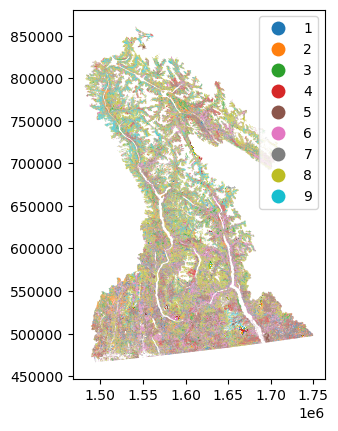

In [14]:
gdf.plot("PROJ_AGE_CLASS_CD_1",legend=True)